## Importando Paquetes

In [112]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow as tf
import csv
import os
import random
import math
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Definiendo constantes, paths, diccionarios y métodos útiles

In [146]:
CLASSNAMES = {
    0 : 'buildings',
    1 : 'barren-land',
    2 : 'water',
    3 : 'grassland', 
    4 : 'roads',
    5 : 'trees', 
}

n_classes = 6
img_shape = 28
n_channels = 3

Estos métodos son para contar filas, contar archivos en determinados directorios, revolver archivos para darle aleatoriedad al input, y una serie de wrappers que facilitan la implementación del código como su lectura

In [147]:
def count_csv_rows(csvfile):
    total_rows = 0
    with open(csvfile, 'rt') as file:
        row_count = sum(1 for row in csv.reader(file))
        total_rows = row_count
    file.close()    
    return total_rows

def count_files(dir_path):
    total_files = 0
    for file in os.listdir(dir_path):
        #avoid invisible files to be counted
        if not file.startswith('.'):
            total_files += 1

    return total_files

def shuffle_files(file1, file2):
    filenames = list(zip(file1, file2))
    random.shuffle(filenames)
    file1, file2 = zip(*filenames)
    return file1, file2

def ConvLayer(input_layer,n_filters,f_shape, name):
    return tf.layers.conv2d(inputs=input_layer, filters=n_filters, kernel_size=f_shape,
        strides=1, padding="same", name=name, activation=tf.nn.relu)

def Pooling(input_layer,name):
    return tf.layers.max_pooling2d(inputs=input_layer, pool_size=2,
        strides=2, padding="same", name=name)

def OutputLayer(dense_layer):
    return tf.layers.dense(inputs=dense_layer, units=n_classes)

## Cargando nuestros datos

In [148]:
# paths for training images and labels, testing images and labels
train_images_dir = '/Users/mac/code/custom-cnn/train_images/'
train_labels_dir = '/Users/mac/code/custom-cnn/train_labels/'
test_images_dir  = '/Users/mac/code/custom-cnn/test_images/'
test_labels_dir = '/Users/mac/code/custom-cnn/test_labels/'

In [149]:
# counting files in those directories (easier to count respective labels)
n_training_labels = count_files(train_labels_dir)
n_testing_labels = count_files(test_labels_dir)
n_training_files = n_training_labels
n_testing_files = n_testing_labels
print('n training files: ',n_training_files)
print('n training labels: ',n_training_labels)
print('n testing files: ',n_testing_files)
print('n testig labels: ',n_testing_labels)

n training files:  10
n training labels:  10
n testing files:  3
n testig labels:  3


Hemos definidos las constantes extract1 y extract2, que disminuyen la cantidad de archivos de images y labels, respectivamente, para hacer una menor cantidad de computaciones (a costa de precisión)

In [150]:
extract1 = 5 # maximo 9
extract2 = 1 # maximo 2

In [151]:
# Lists of all img files and labels
training_filenames = [(train_images_dir+'X_train_%d.csv' % i) for i in range(1,n_training_files-extract1 +1)]
training_labels = [(train_labels_dir+'train_labels_%d.csv' % i) for i in range(1,n_training_labels-extract1 +1)]

testing_filenames = [(test_images_dir+'X_test_%d.csv' % i) for i in range(1,n_testing_files-extract2 +1)]
testing_labels = [(test_labels_dir+'test_labels_%d.csv' % i) for i in range(1,n_testing_labels-extract2 +1)]

print('number of training files we are using:', len(training_filenames))
print('number of training labels we are using:', len(training_labels))
print('number of testing files we are using:', len(testing_filenames))
print('number of testing labels we are using:', len(testing_labels))

number of training files we are using: 5
number of training labels we are using: 5
number of testing files we are using: 2
number of testing labels we are using: 2


In [152]:
# Shuffling files
training_filenames, training_labels = shuffle_files(training_filenames, training_labels)
testing_filenames, testing_labels = shuffle_files(testing_filenames, testing_labels)

In [153]:
# Just one file with its respective label for a quick review 
train_file_path = train_images_dir+'X_train_7.csv'
train_label_path = train_labels_dir+'train_labels_7.csv'

# and a testing case
test_file_path = test_images_dir+'X_test_3.csv'
test_label_path =test_labels_dir+'test_labels_3.csv'

# Counting examples per file 
n_rows_train_file = count_csv_rows(train_label_path)
n_rows_test_file = count_csv_rows(test_label_path)

print('number of rows in training file:', n_rows_train_file)
print('number of rows in testing file:', n_rows_test_file)

number of rows in training file: 32400
number of rows in testing file: 16200


# Métodos de Preprocessing

In [154]:
# este metodo tiene como proposito facilitar la visualizacion de las siguientes imagenes
def process_data_for_visualization(train_path, label_path, img_shape, n_rows):
    # Pre-processing data. Returns numpy arrays
    img_df = pd.read_csv(train_path, nrows=n_rows, header=None) 
    labels_df = pd.read_csv(label_path, nrows=n_rows, header=None)
    np_x = img_df.values.astype(np.uint8)
    np_x = np_x.reshape(-1, img_shape, img_shape, 4)
    np_x = np_x[:, :, :, :3]
    np_x = np_x/255

    y = labels_df.values.astype(np.uint8)
    y = np.argmax(y, axis=1)

    return np_x, y

# est emetodo tiene como proposito el procesamiento de los datos para el modelo
def process_data(img_df, labels_df, img_shape):
    # Pre-processing data. Returns numpy arrays
    np_x = img_df.values.astype(np.uint8)
    np_x = np_x.reshape(-1, img_shape, img_shape, 4)
    np_x = np_x[:, :, :, :3]
    np_x = np_x/255

    np_y = labels_df.values.astype(np.uint8)

    return np_x, np_y

Verificamos las dimensiones de nuestros datos una vez procesados

In [155]:
images, labels = process_data_for_visualization(test_file_path, test_label_path, img_shape, 50)

In [156]:
print(images.shape, labels.shape)

(50, 28, 28, 3) (50,)


## Visualización previa de nuestro dataset

 Para formarnos una idea de las imágenes con las que estamos trabajando, ploteamos  muestras, y guardamos un ejemplo de cada una de las clases, que nos servirán para testear el comportamiento de nuestra red

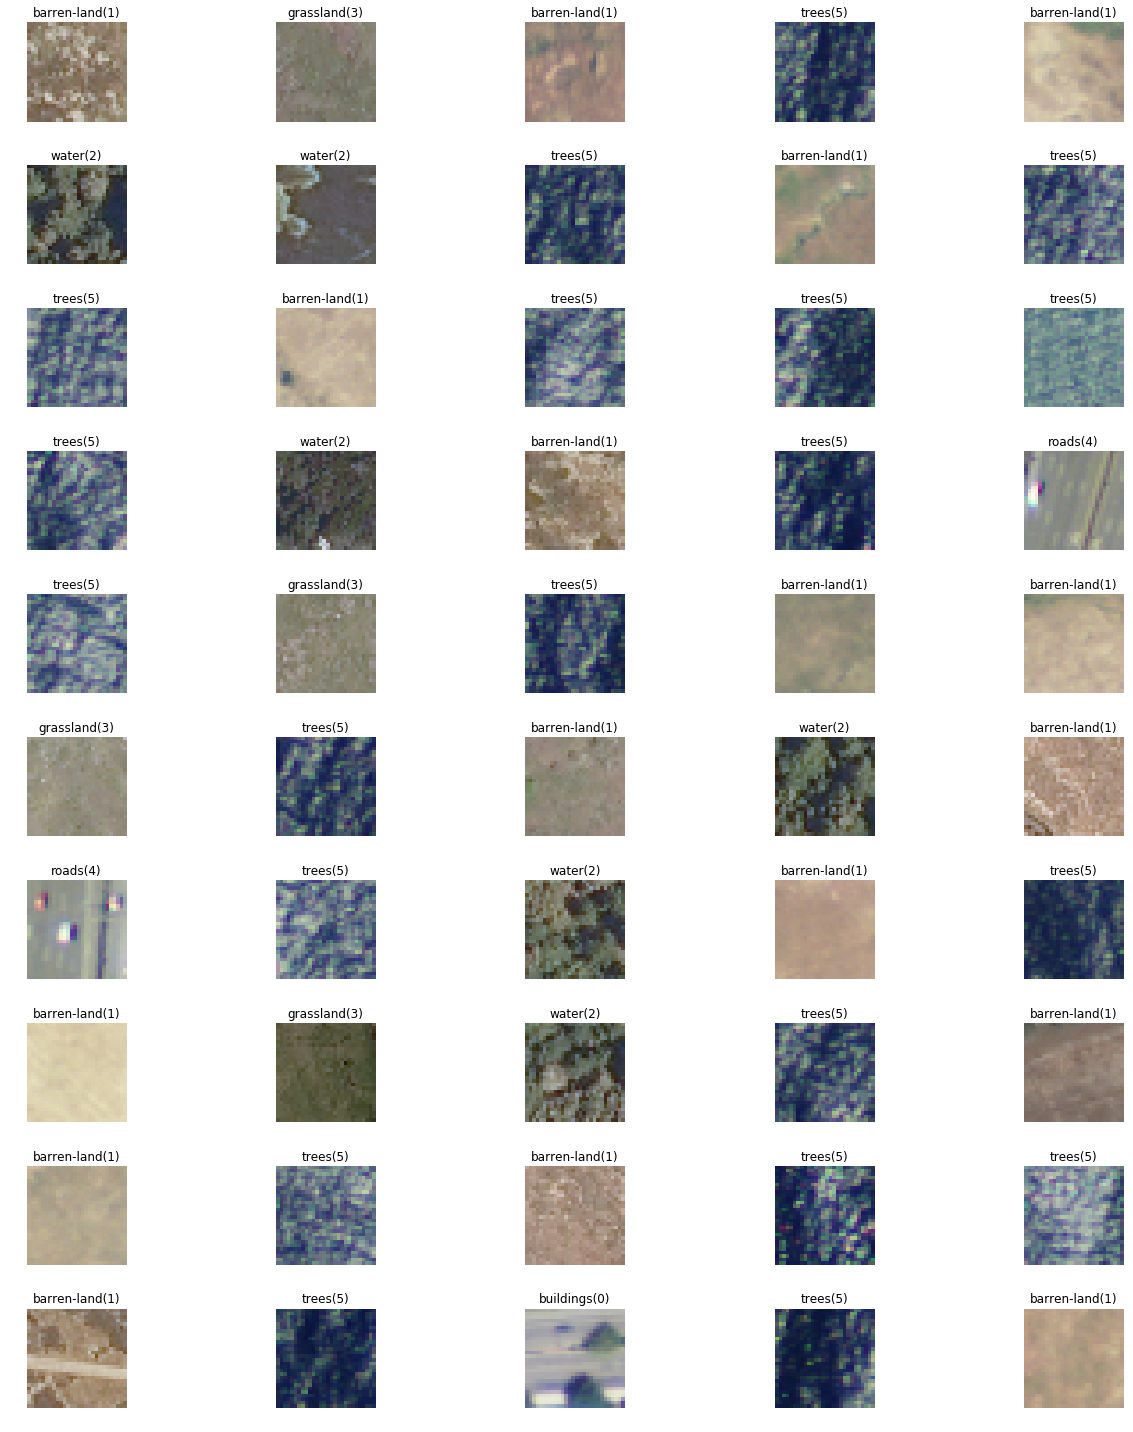

In [157]:
fig, m_axs = plt.subplots(10, images.shape[0]//10, figsize = (20, 20))
# Vector que guarda una imagen de cada clase
img_vector = []
label_vector = []
for (x, y, c_ax) in zip(images, labels, m_axs.flatten()):
    c_ax.imshow(x, interpolation = 'none')
    c_ax.axis('off')
    c_ax.set_title(((CLASSNAMES[y])+"({})").format(y))
    plt.tight_layout()
    if (y not in label_vector):
        img_vector.append(x)
        label_vector.append(y)    

## Visualización del vector que contiene una imagen de cada clase

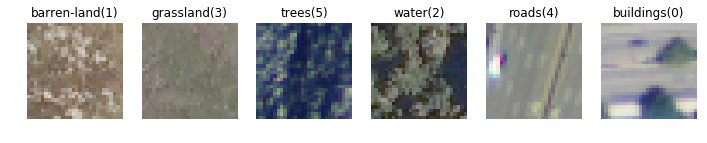

In [158]:
fig, m_axs = plt.subplots(1, 6, figsize = (12, 12))
for (x, y, c_ax) in zip(img_vector, label_vector, m_axs.flatten()):
    c_ax.imshow(x, interpolation = 'none')
    c_ax.axis('off')
    c_ax.set_title(((CLASSNAMES[y])+"({})").format(y))

# Defimos nuestro modelo

In [159]:
tf.reset_default_graph()
# Hyperparameters and constants regarding each dataset
epochs = 1
learning_rate = 0.001 
batch_size = n_rows_train_file//100
test_batch_size = n_rows_test_file//100
print('batch size:', batch_size)

# Defining data placeholders
x = tf.placeholder(tf.float32, [None, 28, 28, 3])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder("float")

# Conv Net and Optimization
n_filters = 32
f_shape = 3

# input -> first layer
conv_layer1 = ConvLayer(x, n_filters, f_shape, 'conv_layer1')
conv_layer2 = ConvLayer(conv_layer1, n_filters, f_shape, 'conv_layer2')
pool_layer1 = Pooling(conv_layer1, 'pool_layer1')

conv_layer3 = ConvLayer(pool_layer1, 2*n_filters, f_shape, 'conv_layer3')
conv_layer4 = ConvLayer(conv_layer3, 2*n_filters, f_shape, 'conv_layer4')
pool_layer2 = Pooling(conv_layer4, 'pool_layer2')

flat_layer = tf.layers.flatten(inputs=pool_layer1)

dense_layer1 = tf.layers.dense(inputs=flat_layer, units=1024, activation= tf.nn.relu)

dropout = tf.layers.dropout(inputs= dense_layer1, rate=keep_prob)

prediction = OutputLayer(dropout)


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))




batch size: 324


# Training

In [160]:
sess= tf.Session()
sess.run(tf.global_variables_initializer())

In [161]:
train_loss = []
train_accuracy = []
summary_writer = tf.summary.FileWriter('./Output', sess.graph)
print("Starting Training...")
for i in range(epochs+1):

    for j in range(len(training_filenames)):
        print("Training File " + str(j) + ": ")
        cnt = 1
        for image_chunk,label_chunk in zip(pd.read_csv(training_filenames[j], header=None, chunksize= batch_size), pd.read_csv(training_labels[j],header=None,chunksize=batch_size)):
            batch_x, batch_y = process_data(image_chunk, label_chunk, img_shape)

            # Run optimization op (backprop).
            opt = sess.run(optimizer, feed_dict={x: batch_x,y: batch_y, keep_prob: 0.5})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            if(cnt%10==0):
                train_loss.append(loss)
                train_accuracy.append(acc)
                print("Batch " + "{:2d}".format(cnt)  + ": Loss= " + \
                              "{:.6f}".format(loss) + ", Training Accuracy= " + \
                              "{:.5f}".format(acc))
                print("Processing next 10 training Batches...")
            cnt+=1

    print("Epoch " + str(i) + ": Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
    print("Processing next epoch...")

print("Training has finished.")


print("Starting Testing...")

total_test_acc = 0
total_test_batches = 1
for k in range(len(testing_filenames)):
    print('Testing File {:.2f}: ', k)
    cnt = 1   
    for image_chunk,label_chunk in zip(pd.read_csv(test_file_path, header=None, chunksize= test_batch_size), pd.read_csv(test_label_path,header=None,chunksize=test_batch_size)):
        test_batch_x, test_batch_y = process_data(image_chunk, label_chunk, img_shape)

        test_acc, test_loss = sess.run([accuracy,cost], feed_dict={x: test_batch_x, y : test_batch_y, keep_prob: 1.0})
        total_test_acc += test_acc
        cnt+=1
        total_test_batches += 1

avg_test_acc = total_test_acc/total_test_batches
print("Testing Accuracy:","{:.5f}".format(avg_test_acc))
    

Starting Training...
Training File 0: 
Batch 10: Loss= 0.811083, Training Accuracy= 0.77160
Processing next 10 training Batches...
Batch 20: Loss= 0.513253, Training Accuracy= 0.83025
Processing next 10 training Batches...
Batch 30: Loss= 0.382017, Training Accuracy= 0.86728
Processing next 10 training Batches...
Batch 40: Loss= 0.242493, Training Accuracy= 0.92593
Processing next 10 training Batches...
Batch 50: Loss= 0.245423, Training Accuracy= 0.89506
Processing next 10 training Batches...
Batch 60: Loss= 0.200303, Training Accuracy= 0.94136
Processing next 10 training Batches...
Batch 70: Loss= 0.247350, Training Accuracy= 0.91975
Processing next 10 training Batches...
Batch 80: Loss= 0.178200, Training Accuracy= 0.91975
Processing next 10 training Batches...
Batch 90: Loss= 0.158589, Training Accuracy= 0.94753
Processing next 10 training Batches...
Batch 100: Loss= 0.146885, Training Accuracy= 0.95679
Processing next 10 training Batches...
Training File 1: 
Batch 10: Loss= 0.2382

Batch 80: Loss= 0.061627, Training Accuracy= 0.98148
Processing next 10 training Batches...
Batch 90: Loss= 0.106293, Training Accuracy= 0.96605
Processing next 10 training Batches...
Batch 100: Loss= 0.106528, Training Accuracy= 0.97222
Processing next 10 training Batches...
Training File 4: 
Batch 10: Loss= 0.091704, Training Accuracy= 0.96296
Processing next 10 training Batches...
Batch 20: Loss= 0.073589, Training Accuracy= 0.97531
Processing next 10 training Batches...
Batch 30: Loss= 0.066380, Training Accuracy= 0.97531
Processing next 10 training Batches...
Batch 40: Loss= 0.096743, Training Accuracy= 0.97531
Processing next 10 training Batches...
Batch 50: Loss= 0.056276, Training Accuracy= 0.97531
Processing next 10 training Batches...
Batch 60: Loss= 0.049710, Training Accuracy= 0.98765
Processing next 10 training Batches...
Batch 70: Loss= 0.100024, Training Accuracy= 0.96605
Processing next 10 training Batches...
Batch 80: Loss= 0.094301, Training Accuracy= 0.97531
Processi

## Visualización del cambio de la función de costos y la precisión 

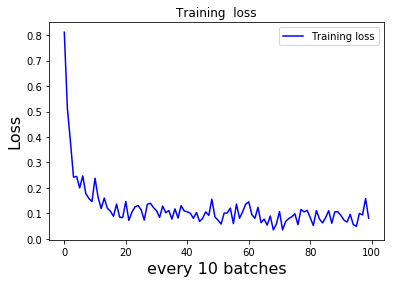

In [162]:
fig1 = plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.title('Training  loss')
plt.xlabel('every 10 batches',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
fig1.savefig('training-loss.png')
plt.show()

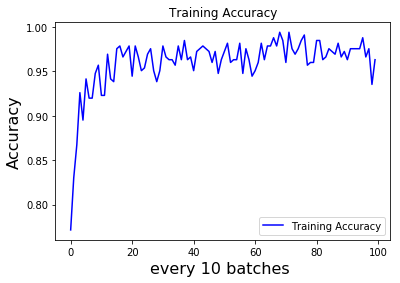

In [163]:
fig2 = plt.figure()
plt.plot(range(len(train_accuracy)), train_accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('every 10 batches ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
fig2.savefig('training-acc.png')
plt.show()

In [164]:
# esta funcion la tome de aqui: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = sess.run(weights)
    print('w shape: ',w.shape)
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    print('num filters:', num_filters)
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    print('num grids:', num_grids)
    n_columns = 4
    n_rows = math.ceil(num_filters / n_columns) + 1
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(n_rows -1, n_columns, figsize=(20,20))
    

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='gray')
            #ax.set_title('Filter ' + str(i+1))
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Visualización de filtros en las primeras Convolutional Layers

Primera capa

w shape:  (3, 3, 3, 32)
num filters: 32
num grids: 6


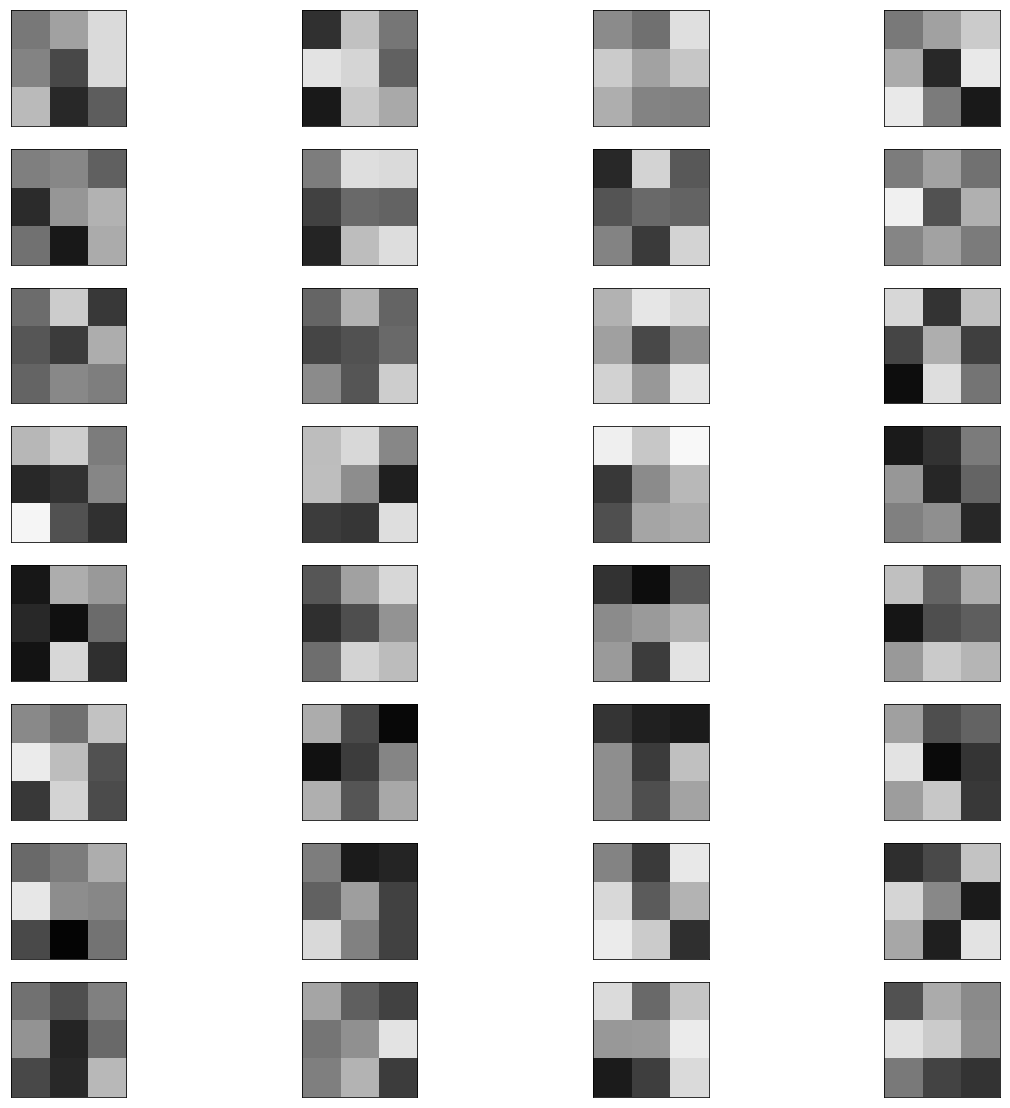

In [165]:
weights_conv_layer_1= tf.get_collection(tf.GraphKeys.VARIABLES, 'conv_layer1/kernel')[0]
plot_conv_weights(weights=weights_conv_layer_1)

Segunda capa

w shape:  (3, 3, 32, 32)
num filters: 32
num grids: 6


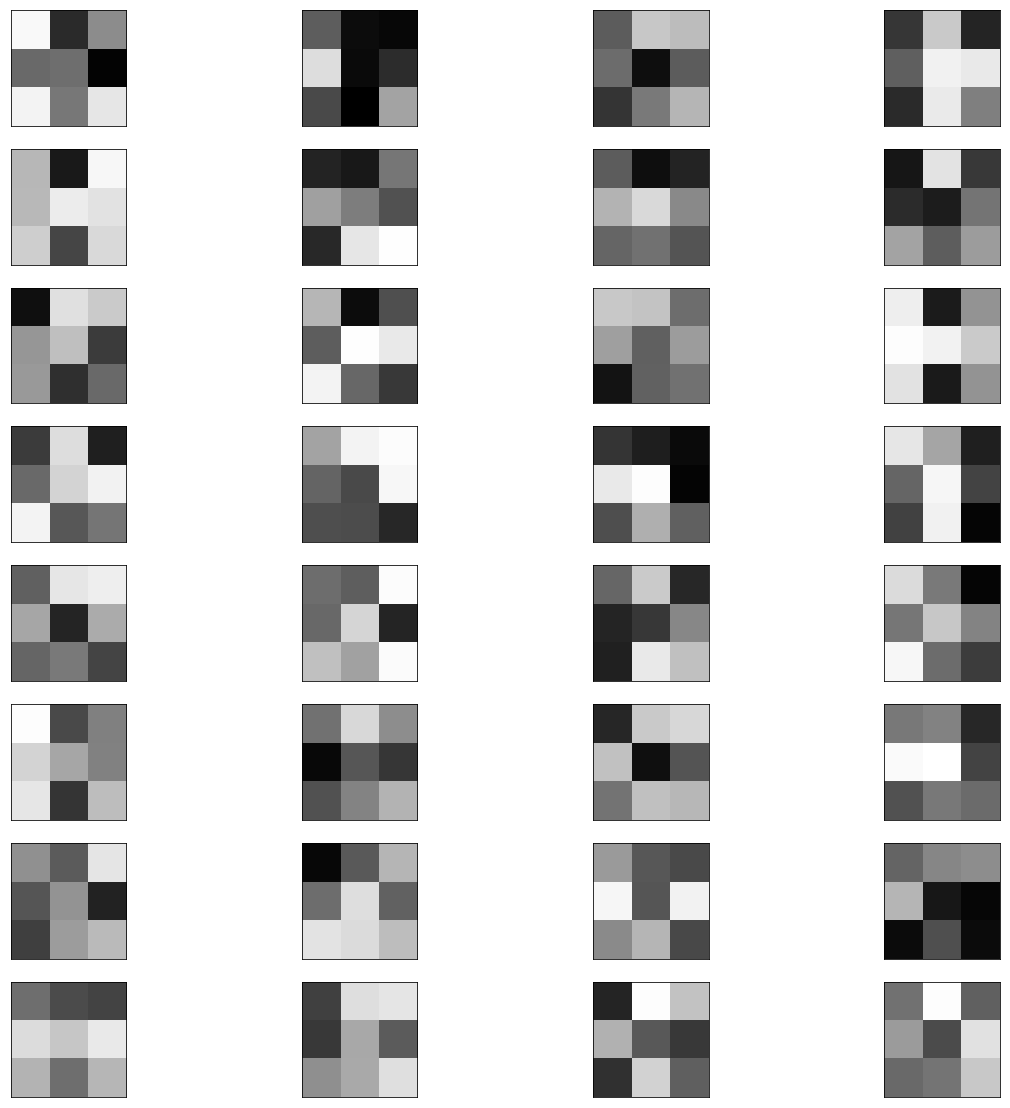

In [166]:
weights_conv_layer_2= tf.get_collection(tf.GraphKeys.VARIABLES, 'conv_layer2/kernel')[0]
plot_conv_weights(weights=weights_conv_layer_2, input_channel = 1)

## Visualización de Activation maps

Para alimentar la red, las imagenes deben estar en un formato específico. definimos entonces una función, feed_format, que utilizaremos después para alimentar cierto layer de la red con el vector de imagenes img_vector y poder visualizar los activation maps en esa capa.


In [177]:
def feed_format(images):
    new_images = np.array(images).reshape(-1,img_shape, img_shape, 3)
    return new_images

Verifiquemos su uso, y el formato que nos entrega

In [178]:
new_img_vector = feed_format(img_vector)
print(new_img_vector.shape)
print(new_img_vector[5:6].shape)

(6, 28, 28, 3)
(1, 28, 28, 3)


definimos la funcion visActivationMaps, que dado un vector de imágenes y un layer de la red específico, podemos visualizar el mapa de activaciones de los filtros que convolucionan sobre esas imágenes

In [179]:
def visActivationMaps(image_vector, labels, layer):
    num_filters = 0
    for k in range(len(image_vector)):
        y = labels[k]
        # ploteamos la imagen que pasa por el layer (i.e una imagen de cada categoria)
        main = plt.figure(figsize=(2,2))
        plt.title('class ' + CLASSNAMES[(y)])
        plt.axis('off')
        #plt.savefig(label_dict[(y)])
        plt.imshow(image_vector[k], cmap='gray')
        new_images = feed_format(image_vector)
        
        x_input = new_images[k:k+1]
        units = sess.run(layer,feed_dict={x: x_input, keep_prob:1.0})
        num_filters = units.shape[3]

        n_columns = 4
        n_rows = math.ceil(num_filters / n_columns) + 1

        fig, axes = plt.subplots(n_rows -1, n_columns, figsize=(14,14))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)


        for i, ax in enumerate(axes.flat):

            if i<num_filters:
                img = units[0, :, :, i]
                # Plot image.
                ax.imshow(img, interpolation='nearest', cmap='gray')
                ax.set_title('Filter ' + str(i+1))

            ax.set_xticks([])
            ax.set_yticks([])
            
    name_of_figure = 'activation-map' + '-' + CLASSNAMES[y]+'-'+str(num_filters)+'-filters.png'
    plt.savefig(name_of_figure)

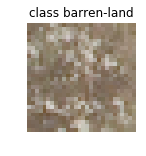

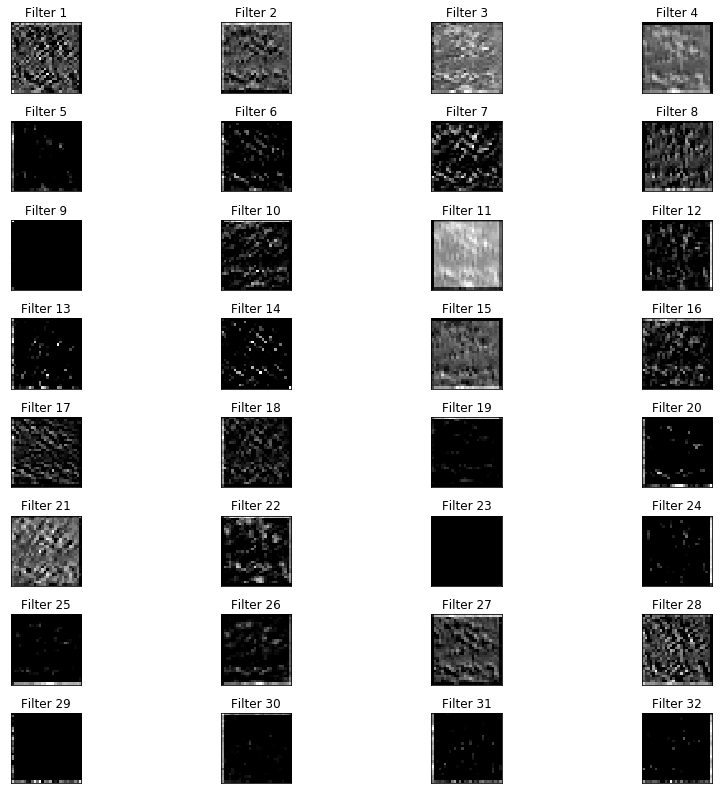

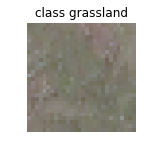

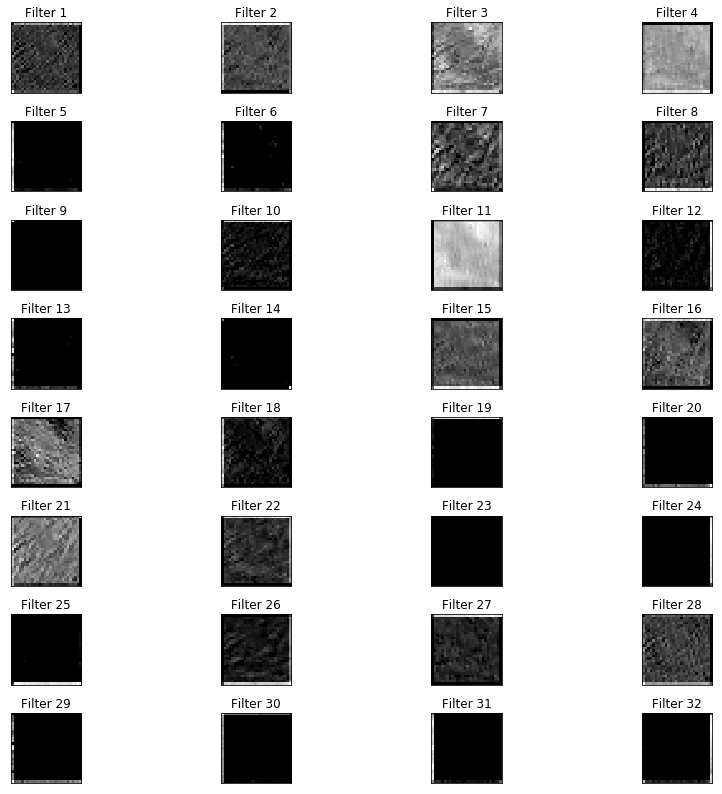

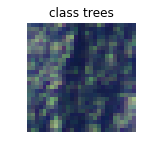

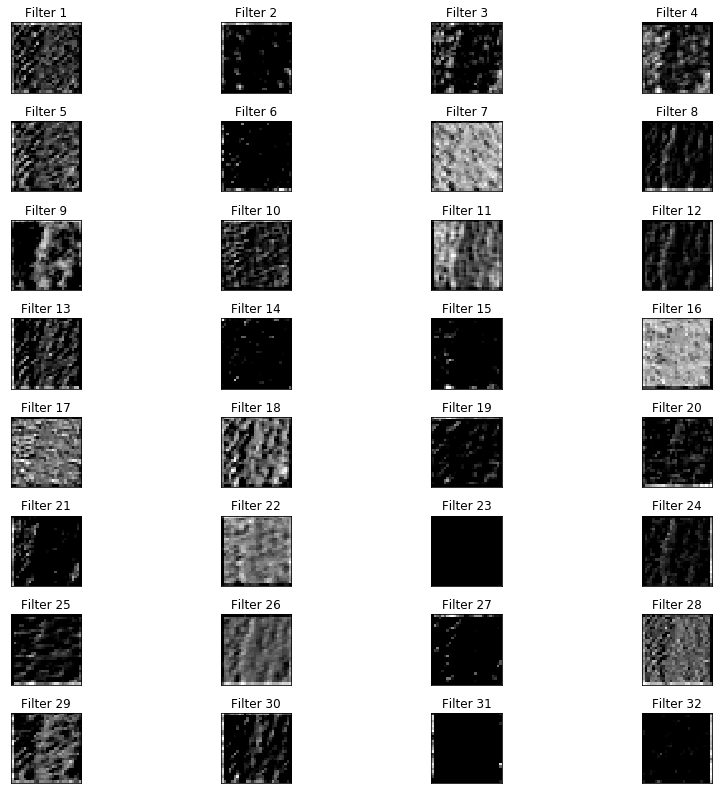

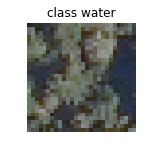

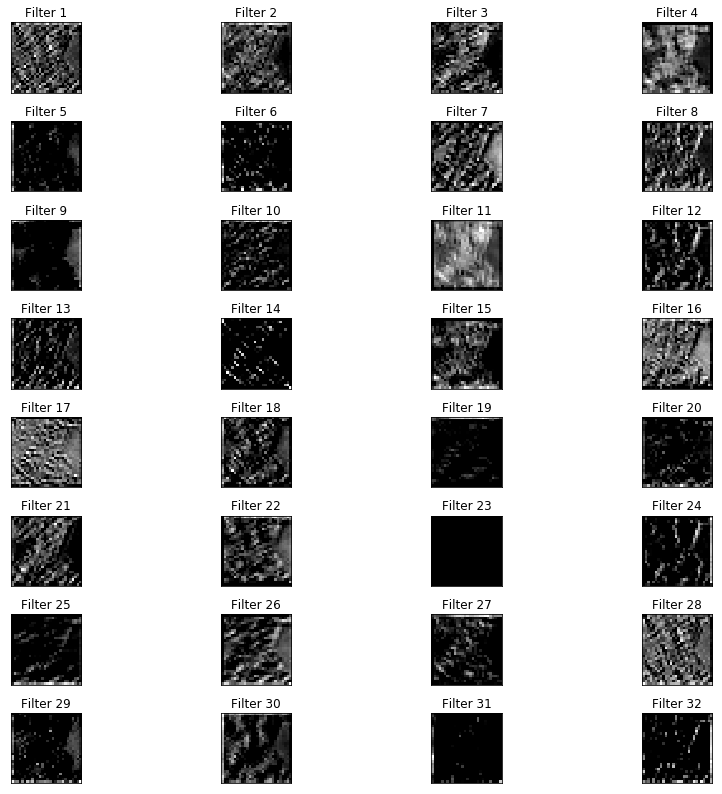

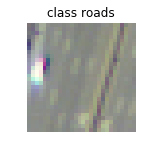

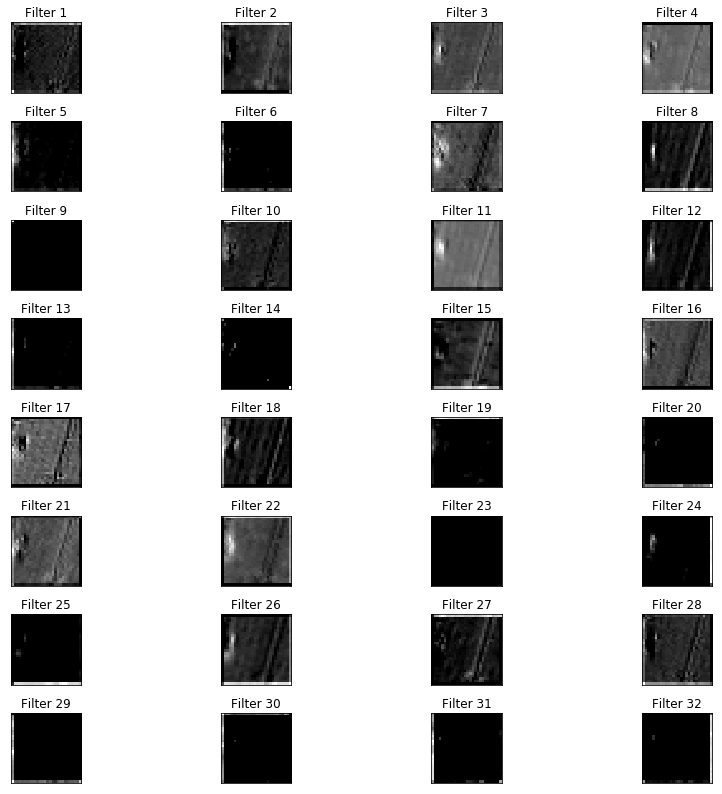

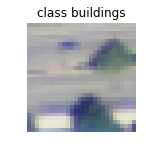

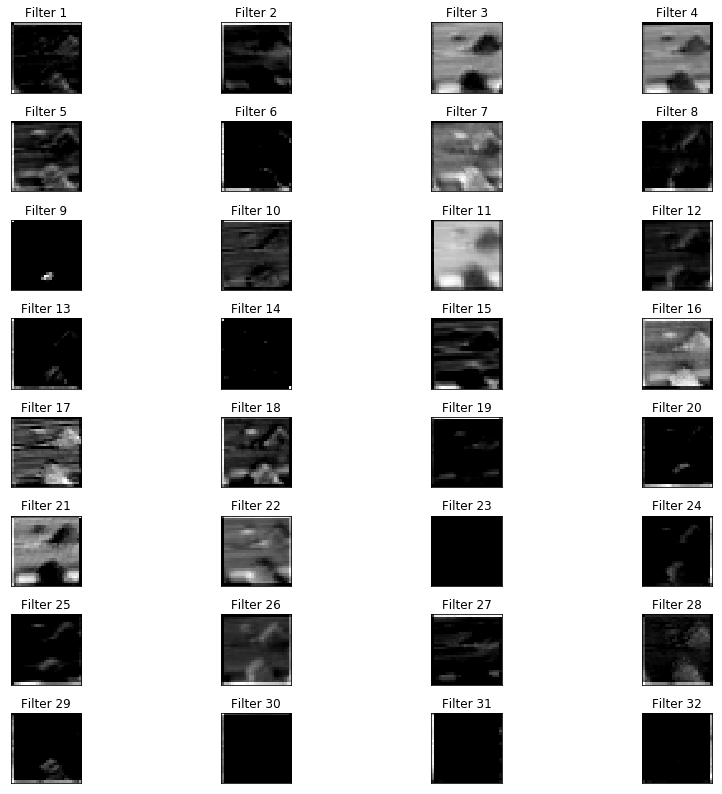

In [180]:
visActivationMaps(img_vector, label_vector, conv_layer1)

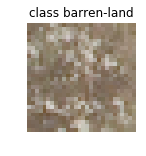

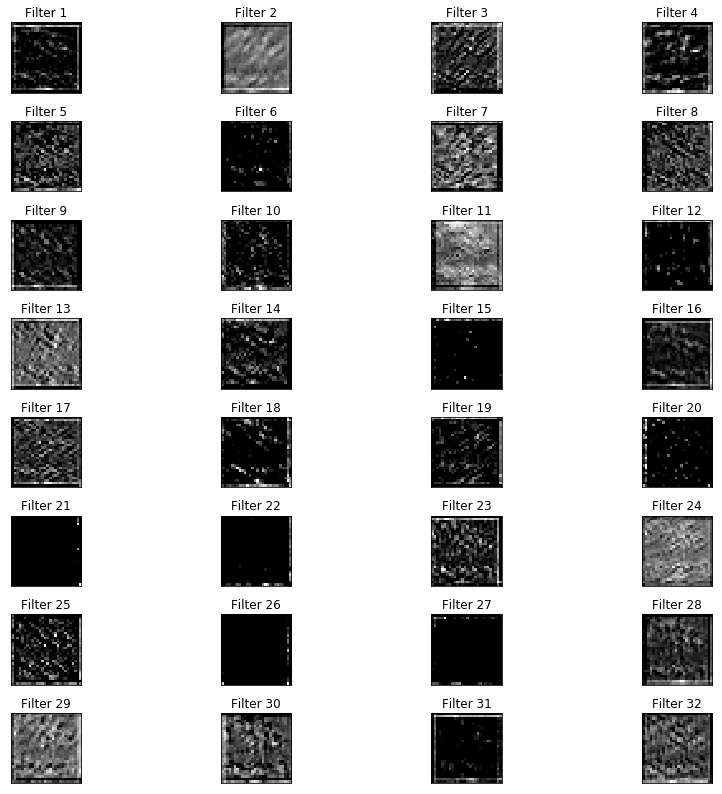

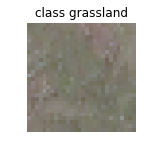

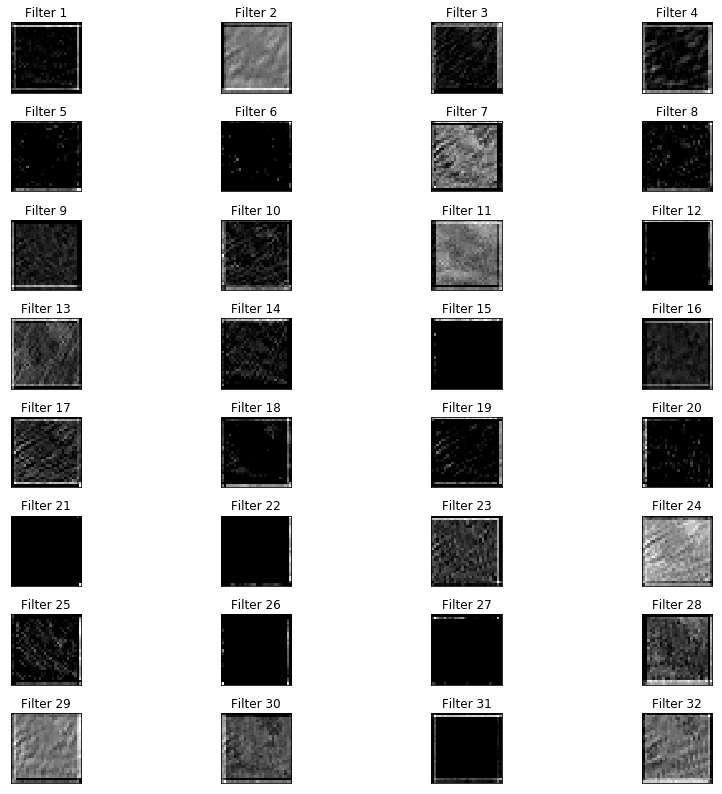

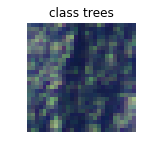

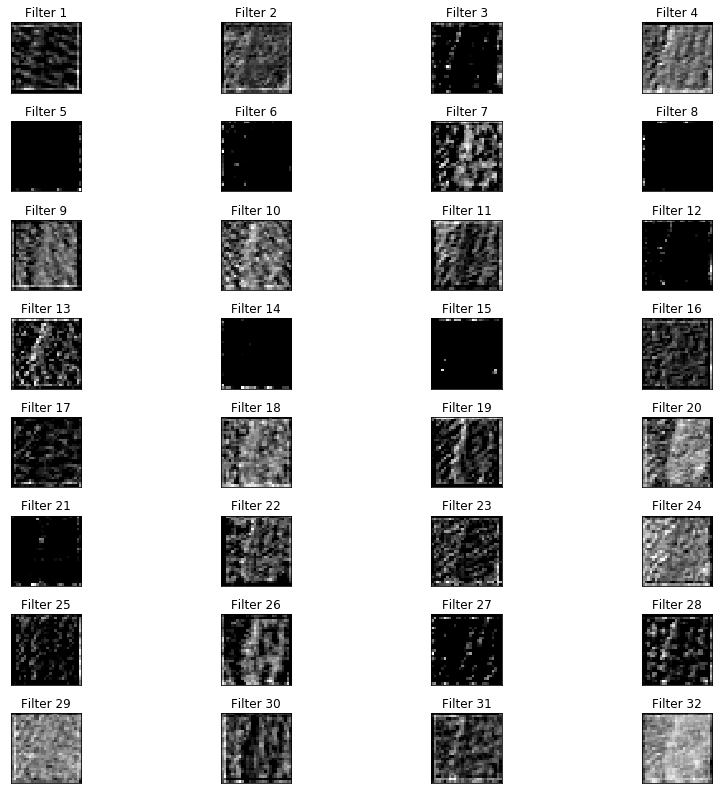

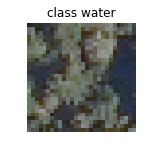

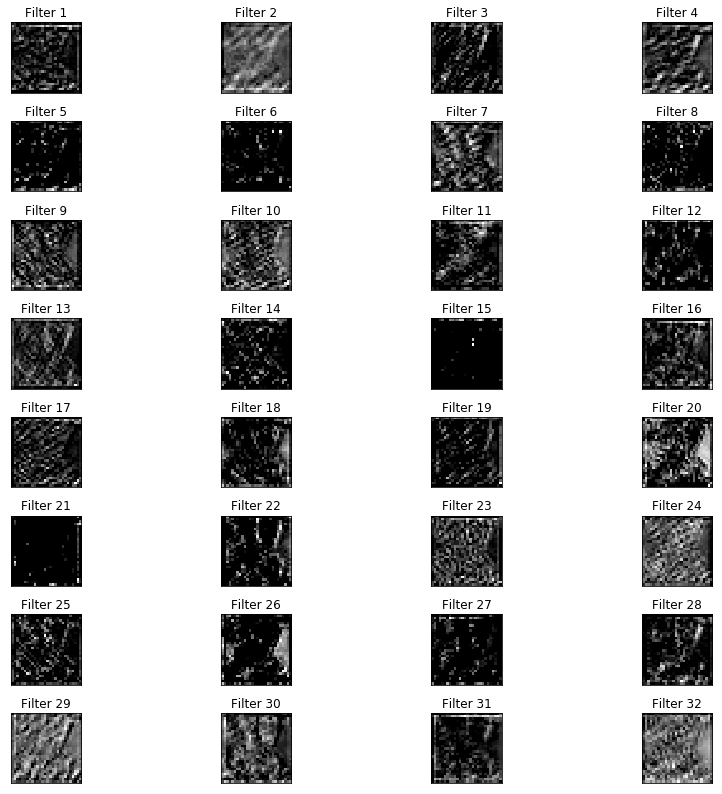

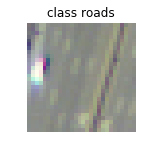

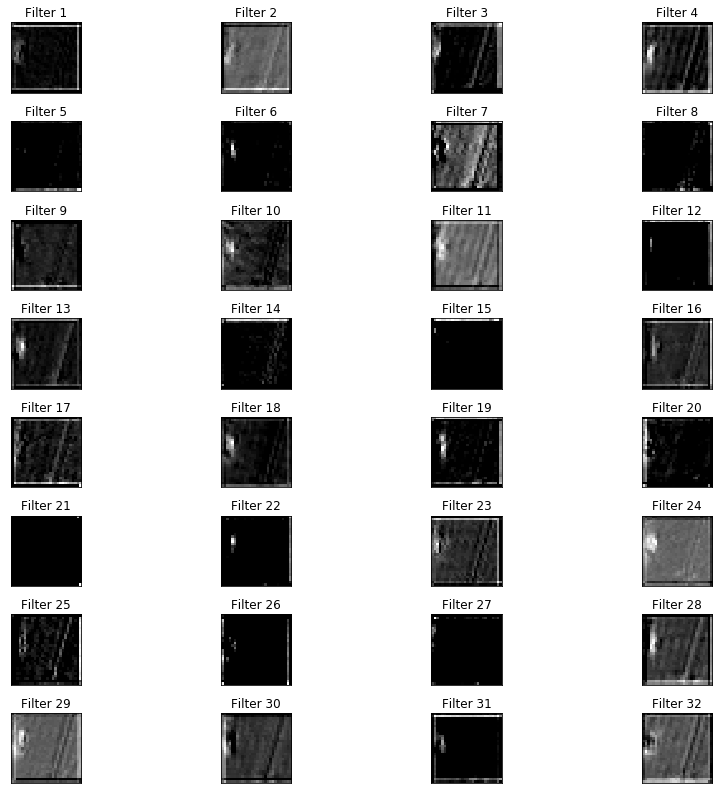

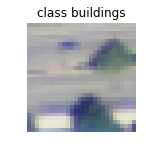

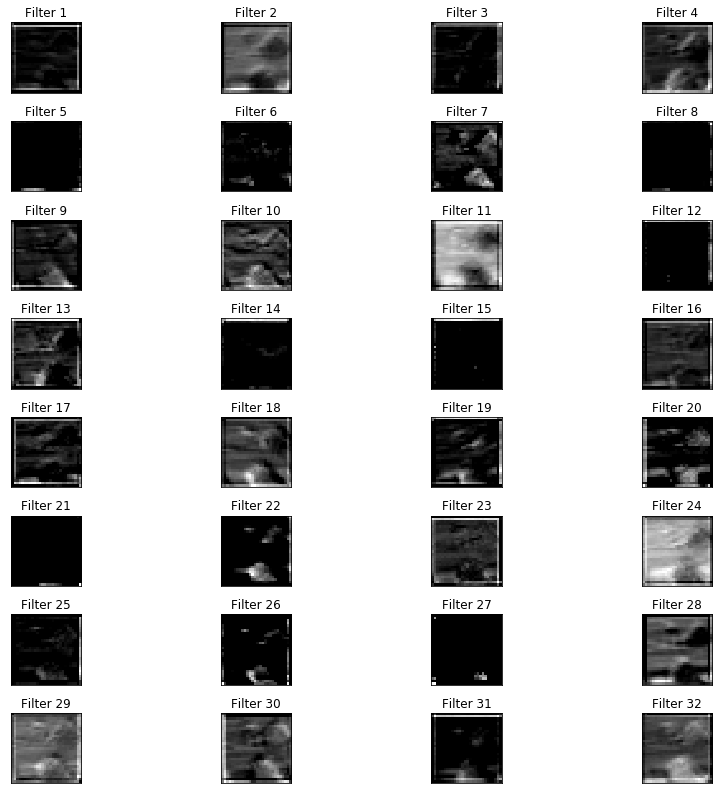

In [181]:
visActivationMaps(img_vector, label_vector, conv_layer2)

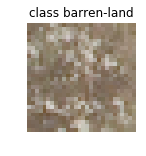

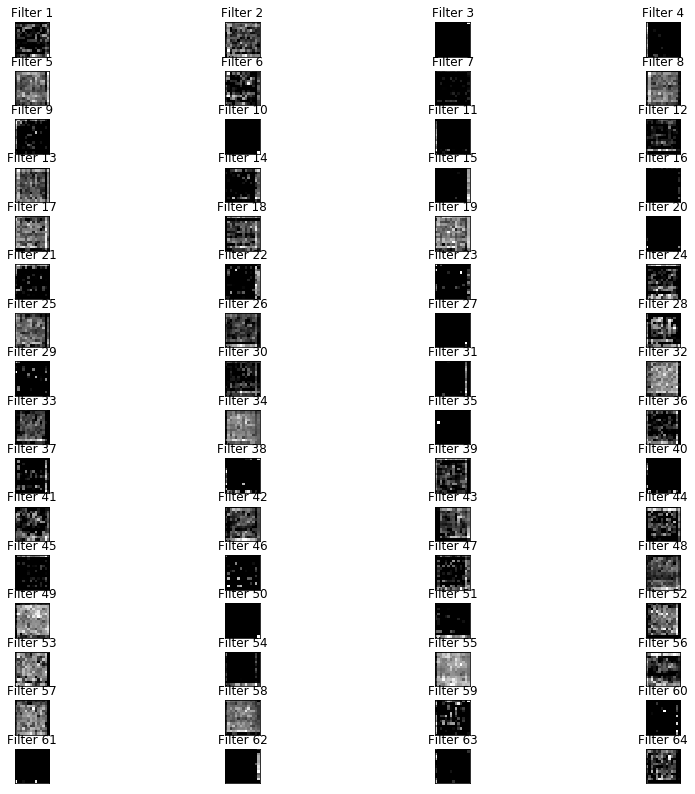

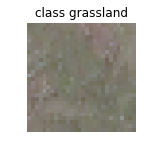

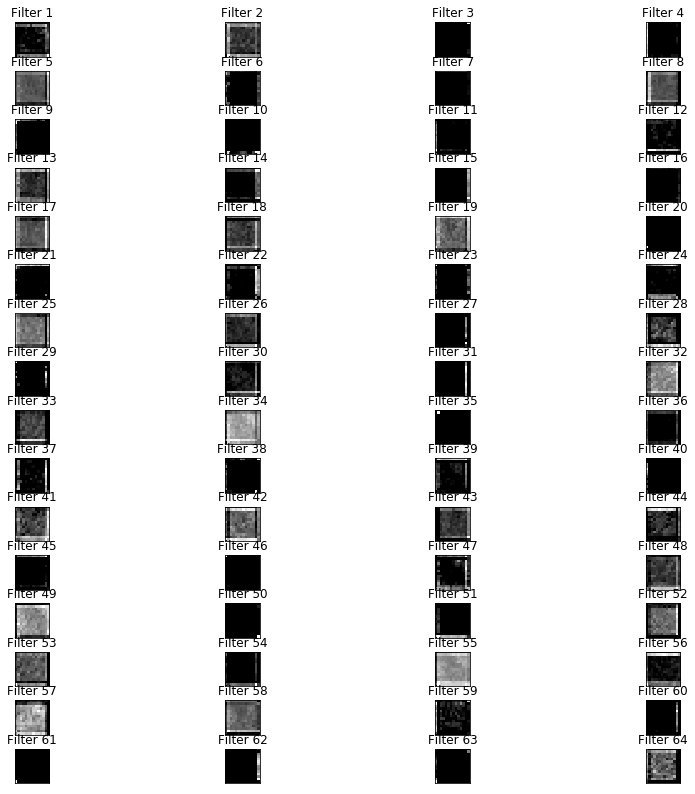

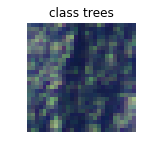

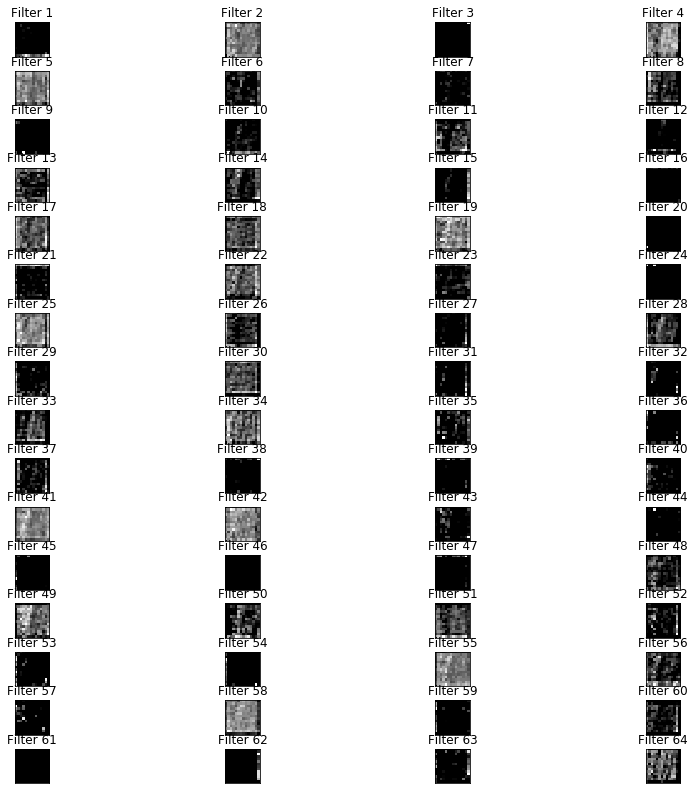

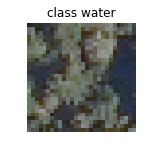

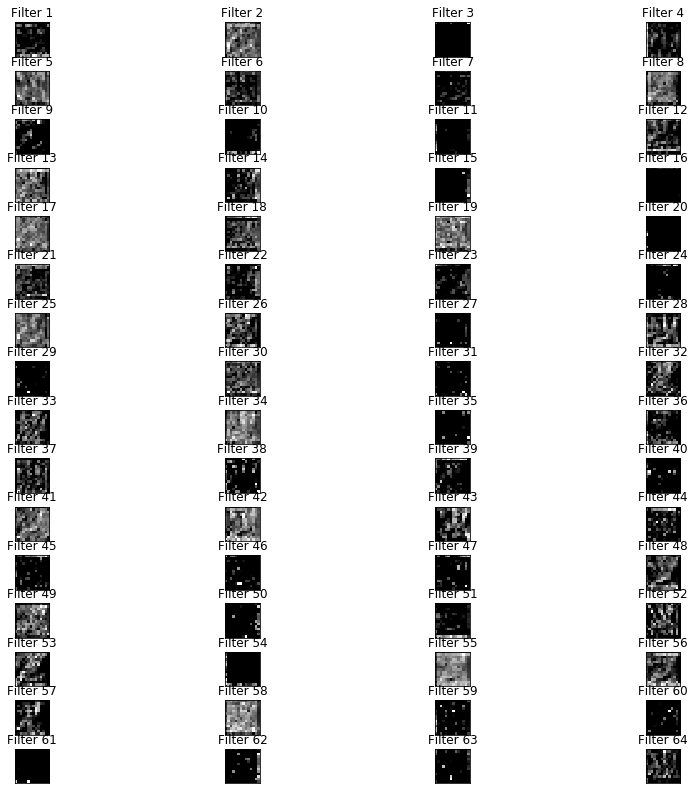

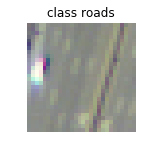

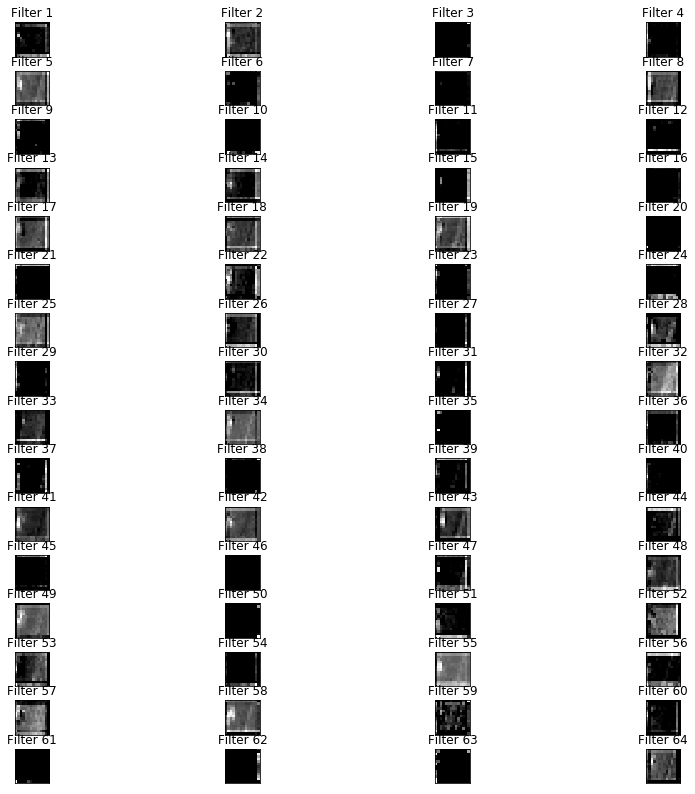

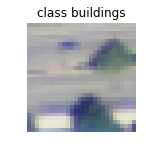

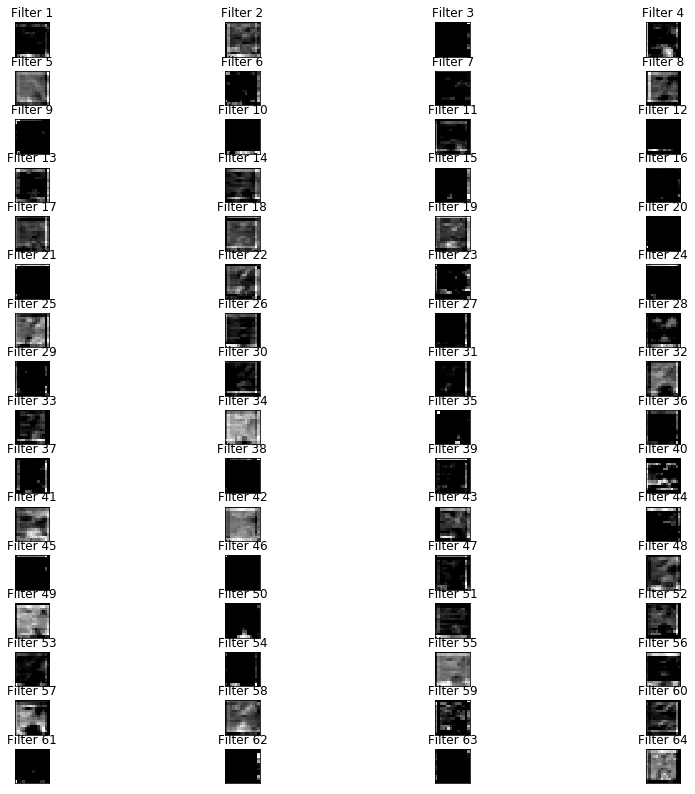

In [182]:
visActivationMaps(img_vector, label_vector, conv_layer3)

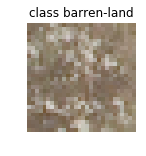

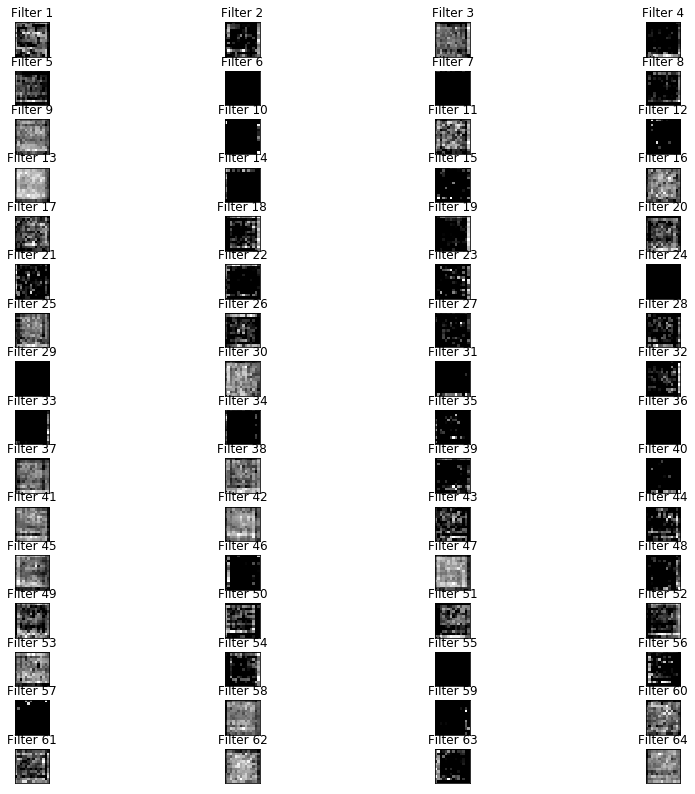

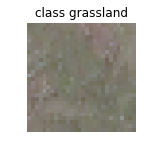

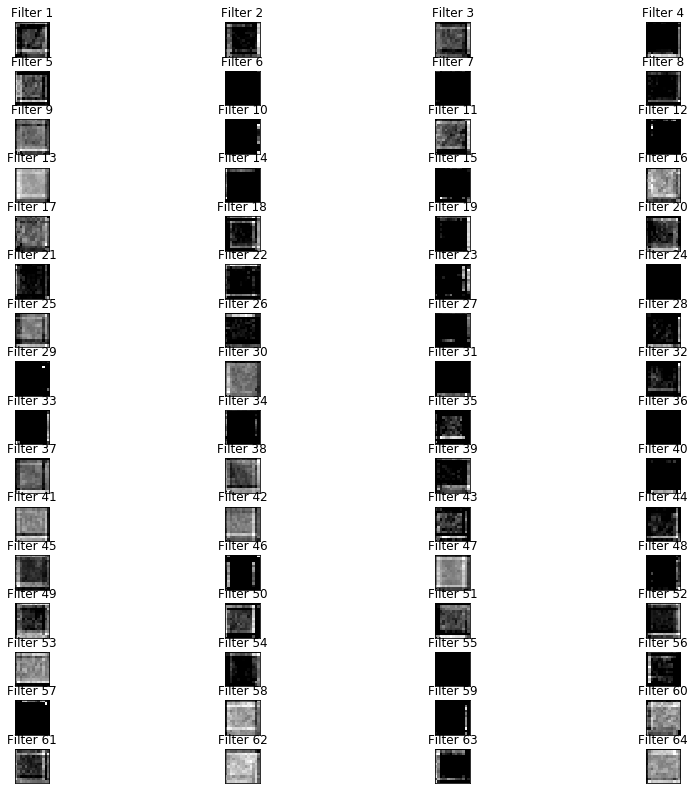

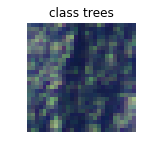

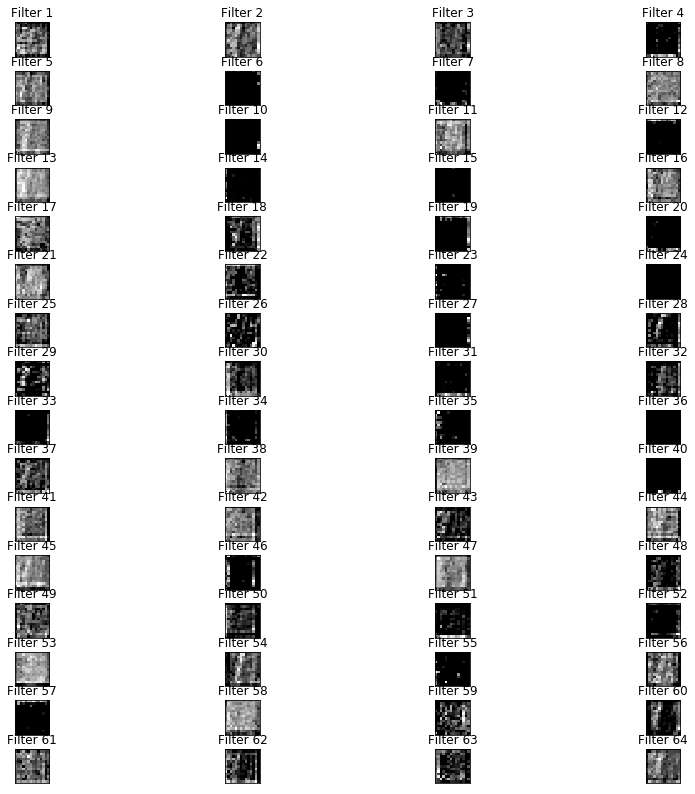

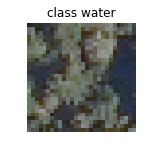

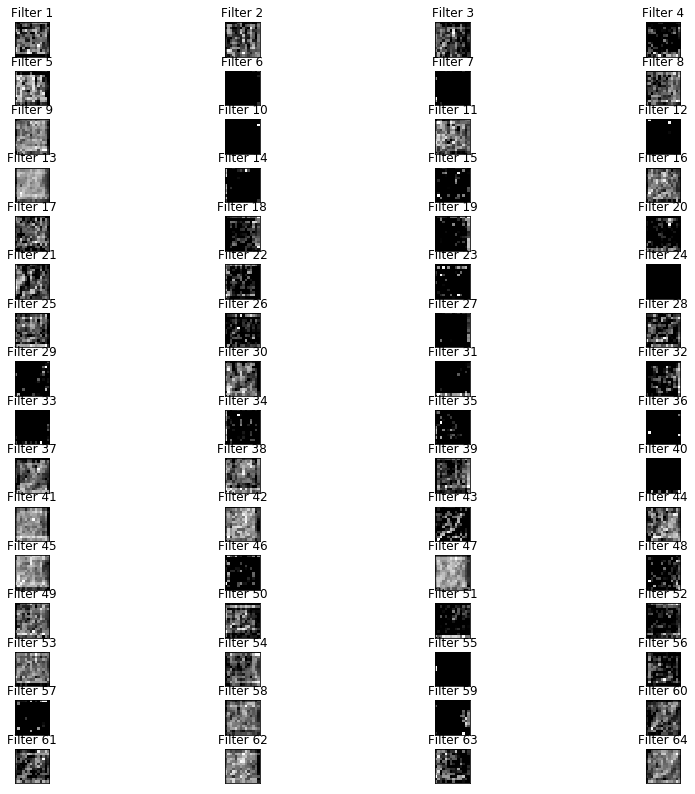

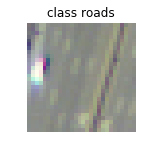

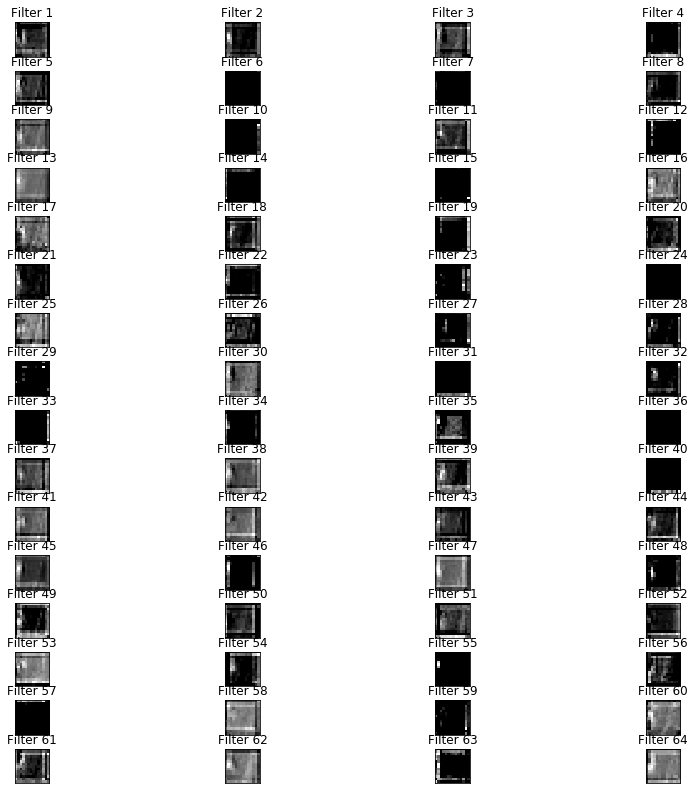

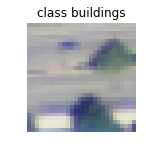

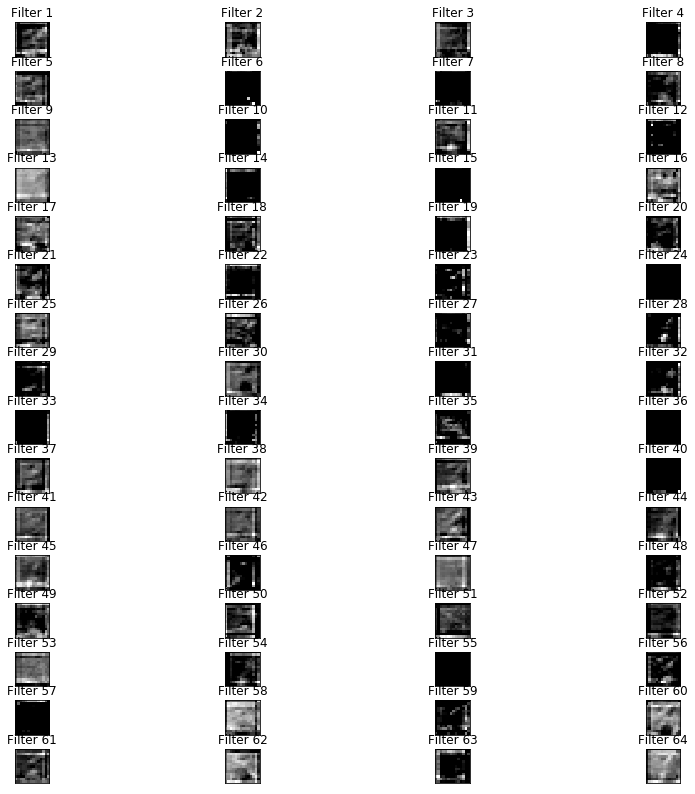

In [183]:
visActivationMaps(img_vector, label_vector, conv_layer4)

In [184]:
sess.close()
tf.reset_default_graph()

# Autoencoder: Unsupervised Learning

TODO: Breve Explicación de lo que es un AutoEncoder, adjuntar Imagen

Diseñaremos un Stacked Autoencoder, que consiste en varios autoencoders, cada uno de ellos entrenados de manera independiente y no supervisada, y en donde el primer autoencoder aprenderá una representación comprimida del input, la cual será utilizada como input para el segundo autoencoder, que aprenderá una repreentación comprimida de este input (y en consecuencia, una mucho más comprimida del input original) y que servirá como input para otro autoencode y así sucesivamente, hasta llegar a un Softmax Layer, que tendremos que entrenar de manera supervisada, y que nos servirá para la clasificación de nuestras imágenes.

## Arquitectura de nuestro modelo

## TODO
hablar de la arquitectura diseñada, que consistirá de 2 autoencoders, con 2 convolutional layers cada uno. Hablar sobre los hiperparámetros de este, el tamaño de los inputs y los autput de cada unos, mencionar si el autoencoder es Sparse, denoise, o variational (que no creo porque es muy dificl)
## TODO: implementar y explicar sparsity

## 1er Autoencoder

In [204]:
tf.reset_default_graph()
n_filters = 32
learning_rate = 0.001
# Input and target placeholders
inputs_1 = tf.placeholder(tf.float32, (None, 28,28,3), name="input_1")
inputs_2 = tf.placeholder(tf.float32, (None, 28,28,3), name="input_2")

# Encoder
conv_1 = ConvLayer(inputs_1, n_filters, f_shape, 'conv_1') # 28x28x3 -> 28X28X32
pool_1 = Pooling(conv_1, 'pool_1') # 28X28X32 ->14x14x32
conv_2 = ConvLayer(pool_1, n_filters, f_shape, 'conv_2') # 14x14x32 -> 14x14x32
pool_2 = Pooling(conv_2, 'pool_2')# 14x14x32 -> 7x7x32
conv_3 = ConvLayer(pool_2, n_filters/2, f_shape, 'conv_3') # 7x7x32 -> 7x7x16 
encoded = Pooling(conv_3, 'encoded') # 7x7x16 -> 4x4x16

#Decoder
upsample1 = tf.image.resize_images(encoded, size=(7,7), 
method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # 4x4x16 -> 7x7x16 

decoder_conv_1 = ConvLayer(upsample1, n_filters, f_shape, 'decoder_conv_1') # 7x7x16 -> 7x7x32

upsample2 = tf.image.resize_images(decoder_conv_1, size=(14,14), 
method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # 7x7x32 -> 14x14x32 

decoder_conv_2 = ConvLayer(upsample2, n_filters, f_shape, 'decoder_conv_2') # 14x14x32  -> 14x14x32

upsample3 = tf.image.resize_images(decoder_conv_2, size=(28,28), 
method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # 14x14x32 -> 28x28x32 

decoder_conv_3 = ConvLayer(upsample3, n_filters, f_shape, 'decoder_conv_3') # 28x28x32  -> 28x28x32

#28x28x32  -> 28x28x3
logits = tf.layers.conv2d(inputs=decoder_conv_3, filters=3, kernel_size=(3,3), padding='same', activation=None)

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=inputs_2, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

In [205]:
extract1 = 9
training_filenames = [(train_images_dir+'X_train_%d.csv' % i) for i in range(1,n_training_files-extract1 +1)]
training_labels = [(train_labels_dir+'train_labels_%d.csv' % i) for i in range(1,n_training_labels-extract1 +1)]

In [206]:
sess= tf.Session() 
sess.run(tf.global_variables_initializer())

In [207]:
epochs = 1
print("Starting 1st Autoencoder Training...")
for i in range(epochs):
    for j in range(len(training_filenames)):
        print('file ',j+1)
        cnt=1
        for image_chunk,label_chunk in zip(pd.read_csv(training_filenames[j], header=None, chunksize= batch_size), pd.read_csv(training_labels[j],header=None,chunksize=batch_size)):
            batch_x, _ = process_data(image_chunk, label_chunk, img_shape)
            # Run optimization op (backprop).
            training_loss, _ = sess.run([cost, opt ], feed_dict={inputs_1: batch_x, inputs_2: batch_x})
            print("Epoch " + str(i) + " Batch "+str(cnt)+": Loss= " + "{:.6f}".format(training_loss))
            cnt+=1
print(" 1st Autoencoder training has finished.")

Starting 1st Autoencoder Training...
file  1
Epoch 0 Batch 1: Loss= 0.693437
Epoch 0 Batch 2: Loss= 0.692628
Epoch 0 Batch 3: Loss= 0.691833
Epoch 0 Batch 4: Loss= 0.690458
Epoch 0 Batch 5: Loss= 0.690463
Epoch 0 Batch 6: Loss= 0.686253
Epoch 0 Batch 7: Loss= 0.684947
Epoch 0 Batch 8: Loss= 0.680591
Epoch 0 Batch 9: Loss= 0.673270
Epoch 0 Batch 10: Loss= 0.669966
Epoch 0 Batch 11: Loss= 0.662495
Epoch 0 Batch 12: Loss= 0.658101
Epoch 0 Batch 13: Loss= 0.657852
Epoch 0 Batch 14: Loss= 0.659618
Epoch 0 Batch 15: Loss= 0.660612
Epoch 0 Batch 16: Loss= 0.651327
Epoch 0 Batch 17: Loss= 0.655478
Epoch 0 Batch 18: Loss= 0.651581
Epoch 0 Batch 19: Loss= 0.649048
Epoch 0 Batch 20: Loss= 0.648275
Epoch 0 Batch 21: Loss= 0.645155
Epoch 0 Batch 22: Loss= 0.644495
Epoch 0 Batch 23: Loss= 0.641851
Epoch 0 Batch 24: Loss= 0.644053
Epoch 0 Batch 25: Loss= 0.647432
Epoch 0 Batch 26: Loss= 0.667997
Epoch 0 Batch 27: Loss= 0.646378
Epoch 0 Batch 28: Loss= 0.659929
Epoch 0 Batch 29: Loss= 0.645370
Epoch 0

## Visualización
### visualización de weights y reconstruccion de imagenes

y = 1 (barren-land)


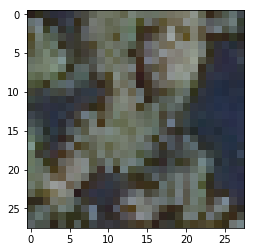

In [229]:
# plotting a Sample
# Get 28x28 image
sample_1 = images[5]
# Get corresponding integer label from one-hot encoded data
sample_label_1 = labels[0]
# Plot sample
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=CLASSNAMES[sample_label_1]))
plt.imshow(sample_1, cmap='gray')

(1, 28, 28, 3)


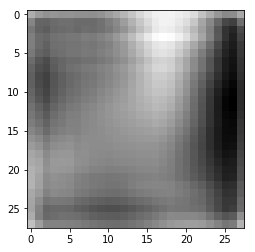

In [230]:
formatted_input = feed_format(sample_1)
reconstructed = sess.run(decoded,feed_dict={inputs_1: formatted_input})
print(reconstructed.shape)
# of this 4-dim tensor.
img = reconstructed[0, :, :, 0]
# Plot image.
plt.imshow(img, cmap='gray')

## 2do Autoencoder

Para entrenar el segundo autoencoder, y siguiendo la arquitectura que elegimos (Stacked) se necesita alimentarlo con la representación comprimida que se generó en el autoencoder anterior (almacenada en la variable encoded). Así, procederemos de la misma forma, con el objetivo de reducir aun más la representación del input original